In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import log_loss,confusion_matrix,classification_report,roc_curve,auc


import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from scipy import sparse
%matplotlib inline
seed = 2390

In [3]:
train = pd.read_csv('C:/Users/tomar/OneDrive/My folder 1/Courses/Kaggle/Toxic Comments/train.csv')
test = pd.read_csv('C:/Users/tomar/OneDrive/My folder 1/Courses/Kaggle/Toxic Comments/test.csv')
print('Number of rows and columns in the train data set:',train.shape)
print('Number of rows and columns in the test data set:',test.shape)

Number of rows and columns in the train data set: (159571, 8)
Number of rows and columns in the test data set: (153164, 2)


In [23]:
#train1=train.head(1000)
#test1=test.head(1000)

In [21]:
sns.countplot?

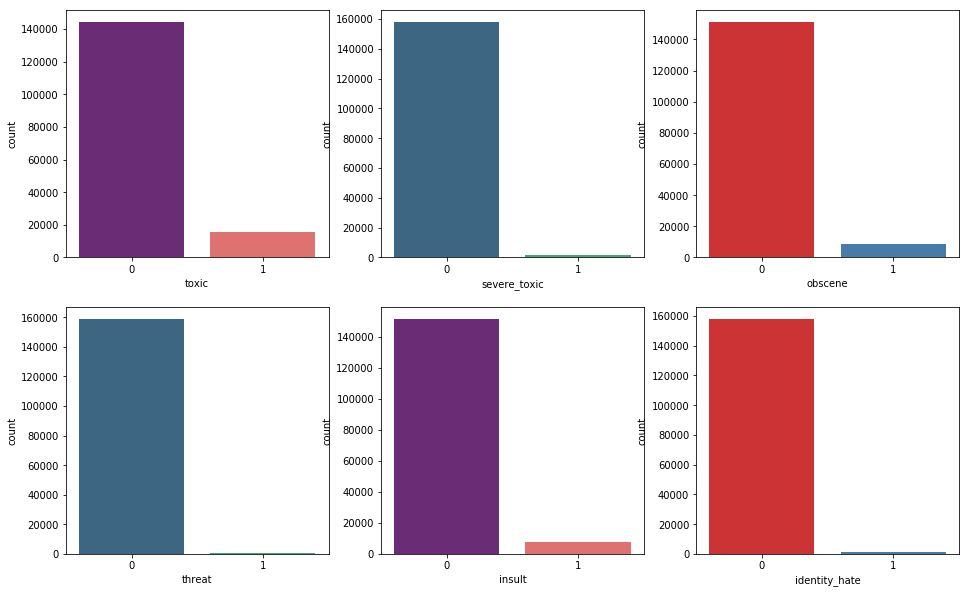

In [4]:
fig,ax = plt.subplots(2,3,figsize=(16,10))
ax1,ax2,ax3,ax4,ax5,ax6 = ax.flatten()
sns.countplot(train['toxic'],palette= 'magma',ax=ax1)
sns.countplot(train['severe_toxic'], palette= 'viridis',ax=ax2)
sns.countplot(train['obscene'], palette= 'Set1',ax=ax3)
sns.countplot(train['threat'], palette= 'viridis',ax = ax4)
sns.countplot(train['insult'], palette = 'magma',ax=ax5)
sns.countplot(train['identity_hate'], palette = 'Set1', ax = ax6)

In [5]:
k = pd.DataFrame()
k['train'] = train.isnull().sum()
k['test'] = test.isnull().sum()
k

,train,test
id,0,0.0
comment_text,0,0.0
toxic,0,NaN
severe_toxic,0,NaN
obscene,0,NaN
threat,0,NaN
insult,0,NaN
identity_hate,0,NaN


In [6]:
vect_word = TfidfVectorizer(max_features=10000, lowercase=True, analyzer='word',
                        stop_words= 'english',ngram_range=(1,2),dtype=np.float32)
vect_char = TfidfVectorizer(max_features=30000, lowercase=True, analyzer='char',
                        stop_words= 'english',ngram_range=(1,6),dtype=np.float32)

In [7]:
train['total_length']=train['comment_text'].apply(len)
train['capital_count']=train['comment_text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
train['exclmtn_mark']=train['comment_text'].apply(lambda comment: comment.count('!'))
train['punctutaion']=train['comment_text'].apply(lambda comment: sum(comment.count(w) for w in '.,;:'))
train['unique_words']=train['comment_text'].apply(lambda comment: len(set(w for w in comment.split())))


test['total_length']=test['comment_text'].apply(len)
test['capital_count']=test['comment_text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
test['exclmtn_mark']=test['comment_text'].apply(lambda comment: comment.count('!'))
test['punctutaion']=test['comment_text'].apply(lambda comment: sum(comment.count(w) for w in '.,;:'))
test['unique_words']=test['comment_text'].apply(lambda comment: len(set(w for w in comment.split())))

In [26]:
tr_vect = vect_word.fit_transform(train['comment_text'])
from scipy.sparse import lil_matrix
tr_vect_char_all=lil_matrix((0,30000))
for i in range(0,16):
    j=10000*i
    k=10000*(i+1)
    
    train1=train[j:k]
    print (train1.shape[:])
    i=i+1
    
    tr_vect_char = vect_char.fit_transform(train1['comment_text'])
    tr_vect_char_all=sparse.vstack([tr_vect_char_all,tr_vect_char])
    
    print (i)
X = sparse.hstack([tr_vect, tr_vect_char_all])
del tr_vect, tr_vect_char,tr_vect_char_all

(10000, 13)
1
(10000, 13)
2
(10000, 13)
3
(10000, 13)
4
(10000, 13)
5
(10000, 13)
6
(10000, 13)
7
(10000, 13)
8
(10000, 13)
9
(10000, 13)
10
(10000, 13)
11
(10000, 13)
12
(10000, 13)
13
(10000, 13)
14
(10000, 13)
15
(9571, 13)
16


In [25]:
tr_vect.shape[:]

(159571, 10000)

In [27]:
ts_vect = vect_word.transform(test['comment_text'])
ts_vect_char = vect_char.transform(test['comment_text'])

x_test = sparse.hstack([ts_vect, ts_vect_char])
del ts_vect, ts_vect_char

In [28]:
target_col = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
y = train[target_col]

In [29]:
prd = np.zeros((x_test.shape[0],y.shape[1]))
cv_score =[]
for i,col in enumerate(target_col):
    lr = LogisticRegression(C=4,random_state = i)
    print('Building {} model for column:{''}'.format(i,col)) 
    lr.fit(X,y[col])
    prd[:,i] = lr.predict_proba(x_test)[:,1]

Building 0 model for column:toxic
Building 1 model for column:severe_toxic
Building 2 model for column:obscene
Building 3 model for column:threat
Building 4 model for column:insult
Building 5 model for column:identity_hate


In [30]:
col = 'identity_hate'

pred =  lr.predict(X)
print(confusion_matrix(y[col],pred))
print(classification_report(y[col],pred))

[[158123     43]
 [   615    790]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    158166
          1       0.95      0.56      0.71      1405

avg / total       1.00      1.00      1.00    159571



Column: identity_hate


Text(0.5,1,'Reciever Operating Characteristic')

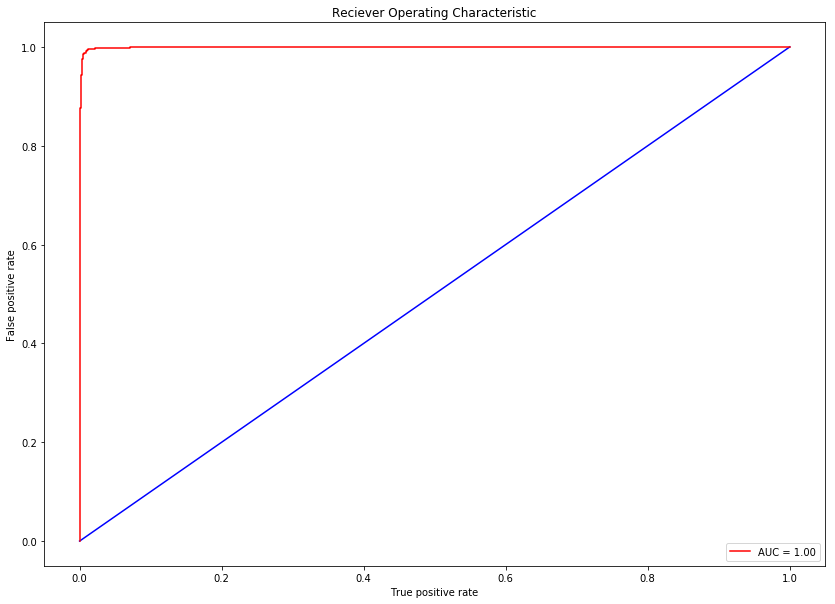

In [31]:
col = 'identity_hate'
print("Column:",col)
pred_pro = lr.predict_proba(X)[:,1]
frp,trp,thres = roc_curve(y[col],pred_pro)
auc_val =auc(frp,trp)
plt.figure(figsize=(14,10))
plt.plot([0,1],[0,1],color='b')
plt.plot(frp,trp,color='r',label= 'AUC = %.2f'%auc_val)
plt.legend(loc='lower right')
plt.xlabel('True positive rate')
plt.ylabel('False positive rate')
plt.title('Reciever Operating Characteristic')

In [32]:
prd_1 = pd.DataFrame(prd,columns=y.columns)
submit = pd.concat([test['id'],prd_1],axis=1)
#submit.to_csv('toxic_lr.csv.gz',compression='gzip',index=False)
submit.to_csv('toxic_lr.csv',index=False)
submit.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999970,0.260945,0.999824,0.057741,0.961351,0.592982
1,0000247867823ef7,0.001143,0.001337,0.001875,0.000384,0.004219,0.000387
2,00013b17ad220c46,0.010696,0.001548,0.014097,0.000181,0.008279,0.000791
3,00017563c3f7919a,0.001208,0.001833,0.001234,0.000746,0.001526,0.000208
4,00017695ad8997eb,0.193480,0.003361,0.009386,0.001038,0.017844,0.002246
